# Chargement des données

Dans mon projet, j'ai choisi de classifier des images associées à 5 labels différents : **vintage**, **classique**, **gothique**, **streetwear** et **chic**.

J'ai réparti mes images dans 3 ensembles (et donc 3 dossiers): *train*, *validation* et *test*. Chacun de ces dossiers comporte un sous-dossier par classe, qui contient les images correspondantes. L'arborescence est résumée sur l'image ci-dessus.

J'ai choisi d'héberger ma base de données sur Github : l'intérêt est qu'un **git clone** depuis Google Colab est très rapide, ce qui vous garantit une certaine simplicité. Je vous encourage à en faire de même.

In [1]:
!git clone https://github.com/TItygrosminet/Projet_Deep_Learning.git
path = "./Projet_Deep_Learning/src/"

fatal: destination path 'Projet_Deep_Learning' already exists and is not an empty directory.


Une fois les données téléchargées localement, on peut maintenant charger les images et les labels. Si vous avez construit votre arborescence de la même manière que la mienne, et que vous adaptez les noms de labels à votre projet, alors le code suivant devrait être utilisable directement.

In [2]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

import cv2


def load_data(data_path, classes, dataset, image_size=128):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = cv2.imread(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = cv2.resize(img, (image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1
                
    return x, y

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [3]:
labels = ['vintage', 'classique', 'gothique', 'streetwear', 'chic']

x, y = load_data(path, labels, dataset='cropped_images', image_size=128)
print(x.shape, y.shape)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
x = x/255

from sklearn.model_selection import train_test_split

x_train, x_gen, y_train, y_gen = train_test_split(x,y, test_size = 3/10)
x_val, x_test, y_val, y_test = train_test_split(x_gen,y_gen, test_size = 1/2)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape


(4230, 128, 128, 3) (4230, 1)


((2961, 128, 128, 3),
 (634, 128, 128, 3),
 (635, 128, 128, 3),
 (2961, 1),
 (634, 1),
 (635, 1))

In [4]:
import pandas as pd

# créer un DataFrame pour stocker les résultats
data = {'classe': labels,
        'train': pd.Series(y_train.ravel()).value_counts(),
        'val': pd.Series(y_val.ravel()).value_counts(),
        'test': pd.Series(y_test.ravel()).value_counts()}

df = pd.DataFrame(data)

print(df)

         classe  train  val  test
0.0     vintage    541  134   118
1.0   classique    699  127   154
2.0    gothique    605  145   132
3.0  streetwear    623  120   133
4.0        chic    493  108    98


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

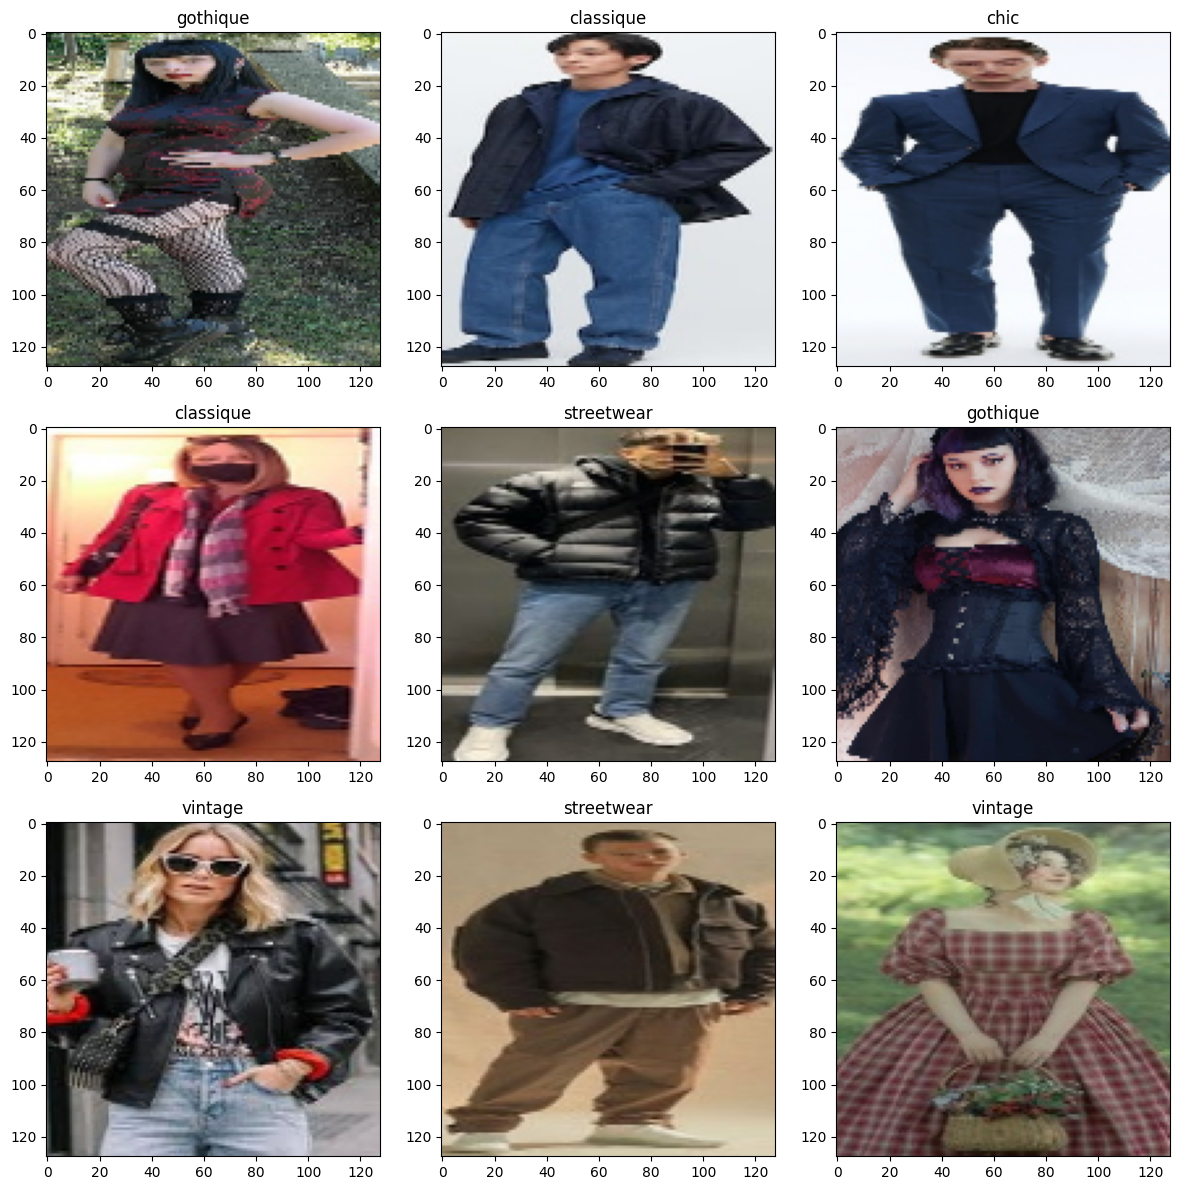

In [5]:
import matplotlib.pyplot as plt
from random import randint
plt.figure(figsize=(12, 12))
shuffle_indices = [randint(0, x.shape[0]) for i in range(9)]
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x[shuffle_indices[i]]
    plt.title(labels[int(y[shuffle_indices[i]])])
    plt.imshow(image)

plt.tight_layout()
plt.show()

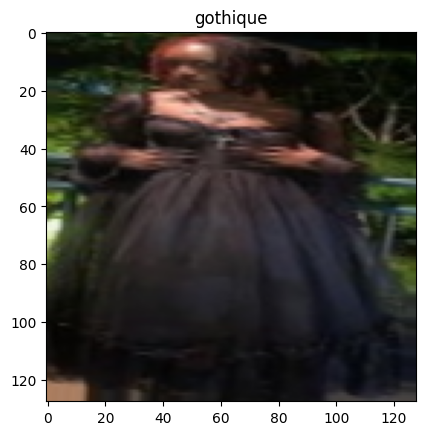

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    vertical_flip=True,          # Randomly flip images horizontally
    rotation_range=5,             # Randomly rotate images by up to 20 degrees
)

example_x, example_y = train_datagen.flow(x_train, y_train, batch_size=1).next()
for i in range(0,1):
    plt.imshow(example_x[i])
    plt.title(labels[int(example_y[i])])
    plt.show()

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

image_size = 128

conv_base = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
)

x = Flatten()(conv_base.output)
x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(126, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)

conv_base.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 300

es = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

history = model.fit(x_train, y_train, batch_size=10, validation_data=(x_val, y_val), epochs=epochs, callbacks=[es])

Epoch 1/300
297/297 [==============================] - 24s 31ms/step - loss: 19.9398 - accuracy: 0.4195 - val_loss: 13.4540 - val_accuracy: 0.7082
Epoch 2/300
297/297 [==============================] - 5s 18ms/step - loss: 10.9705 - accuracy: 0.6224 - val_loss: 8.7096 - val_accuracy: 0.7019
Epoch 3/300
297/297 [==============================] - 6s 20ms/step - loss: 7.4936 - accuracy: 0.7001 - val_loss: 6.2843 - val_accuracy: 0.7792
Epoch 4/300
297/297 [==============================] - 5s 17ms/step - loss: 5.5651 - accuracy: 0.7609 - val_loss: 4.9337 - val_accuracy: 0.7808
Epoch 5/300
297/297 [==============================] - 6s 19ms/step - loss: 4.4060 - accuracy: 0.7937 - val_loss: 4.0985 - val_accuracy: 0.7366
Epoch 6/300
297/297 [==============================] - 5s 17ms/step - loss: 3.5911 - accuracy: 0.8105 - val_loss: 3.3932 - val_accuracy: 0.7666
Epoch 7/300
297/297 [==============================] - 5s 18ms/step - loss: 2.9966 - accuracy: 0.8247 - val_loss: 2.9494 - val_accur

In [9]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

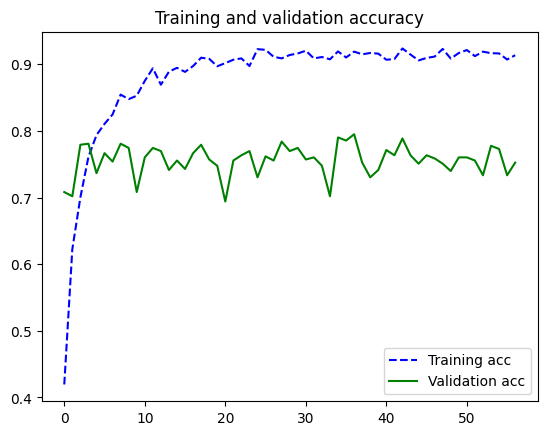

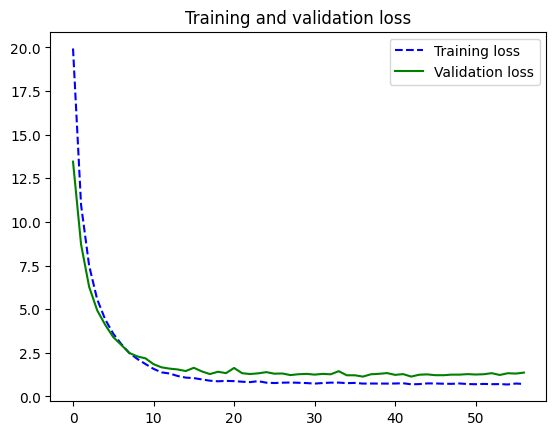

In [10]:
plot_training_analysis()

In [11]:
conv_base.trainable = True

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=10, validation_data=(x_val, y_val), epochs=epochs, callbacks=[es])

Epoch 1/300
297/297 [==============================] - 47s 44ms/step - loss: 1.5732 - accuracy: 0.6160 - val_loss: 1.1835 - val_accuracy: 0.7744
Epoch 2/300
297/297 [==============================] - 11s 38ms/step - loss: 1.3588 - accuracy: 0.6734 - val_loss: 1.1307 - val_accuracy: 0.7839
Epoch 3/300
297/297 [==============================] - 11s 37ms/step - loss: 1.2103 - accuracy: 0.7288 - val_loss: 1.1341 - val_accuracy: 0.7744
Epoch 4/300
297/297 [==============================] - 11s 38ms/step - loss: 1.1323 - accuracy: 0.7558 - val_loss: 1.1164 - val_accuracy: 0.7760
Epoch 5/300
297/297 [==============================] - 11s 38ms/step - loss: 1.0041 - accuracy: 0.8102 - val_loss: 1.0868 - val_accuracy: 0.7697
Epoch 6/300
297/297 [==============================] - 11s 37ms/step - loss: 0.9510 - accuracy: 0.8284 - val_loss: 1.0815 - val_accuracy: 0.7729
Epoch 7/300
297/297 [==============================] - 11s 38ms/step - loss: 0.8754 - accuracy: 0.8517 - val_loss: 1.0638 - val_ac

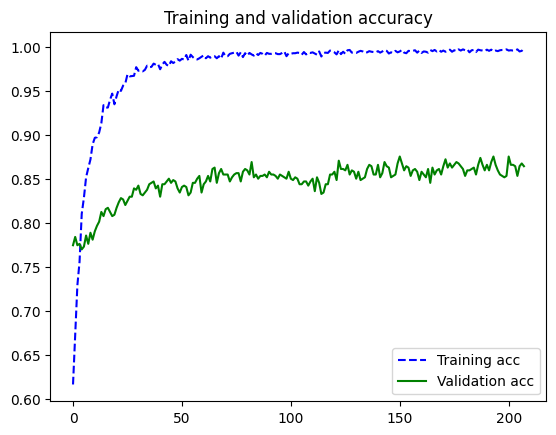

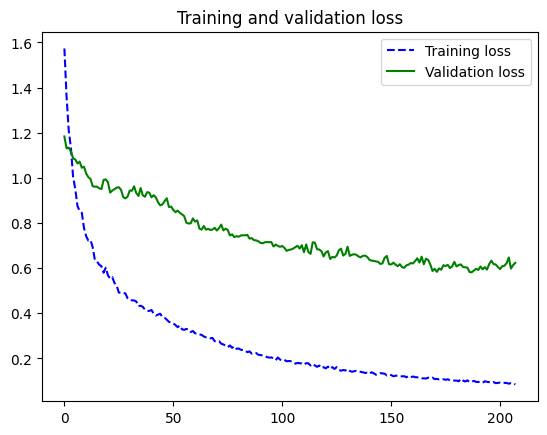

In [12]:
plot_training_analysis()

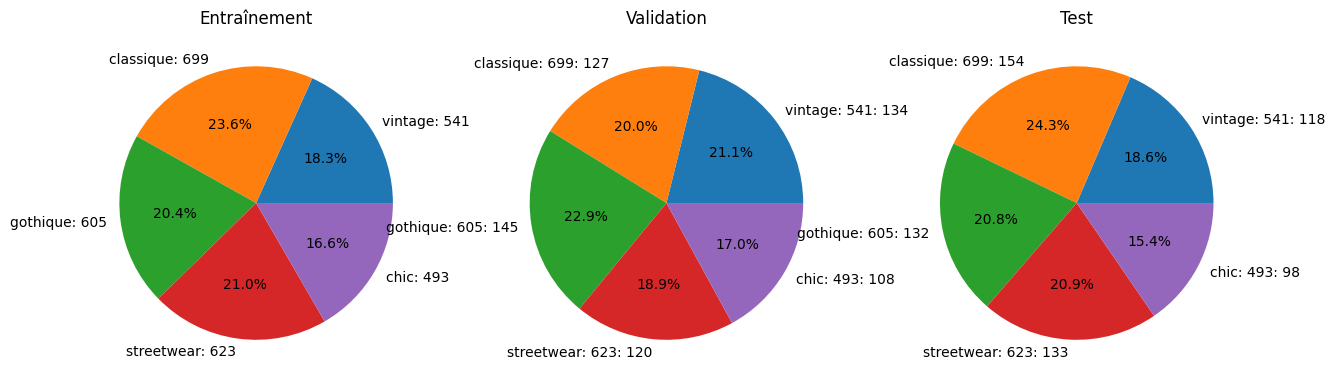

In [13]:
# Nombre d'images par classe
train_counts = np.unique(y_train, return_counts=True)[1]
val_counts = np.unique(y_val, return_counts=True)[1]
test_counts = np.unique(y_test, return_counts=True)[1]

# Création des labels pour l'affichage
labels = ['{}: {}'.format(labels[i], count) for i, count in enumerate(train_counts)]
labels_val = ['{}: {}'.format(labels[i], count) for i, count in enumerate(val_counts)]
labels_test = ['{}: {}'.format(labels[i], count) for i, count in enumerate(test_counts)]

# Affichage des nombres d'images par classe
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].pie(train_counts, labels=labels, autopct='%1.1f%%')
ax[0].set_title('Entraînement')
ax[1].pie(val_counts, labels=labels_val, autopct='%1.1f%%')
ax[1].set_title('Validation')
ax[2].pie(test_counts, labels=labels_test, autopct='%1.1f%%')
ax[2].set_title('Test')
plt.show()

20/20 [==============================] - 2s 36ms/step


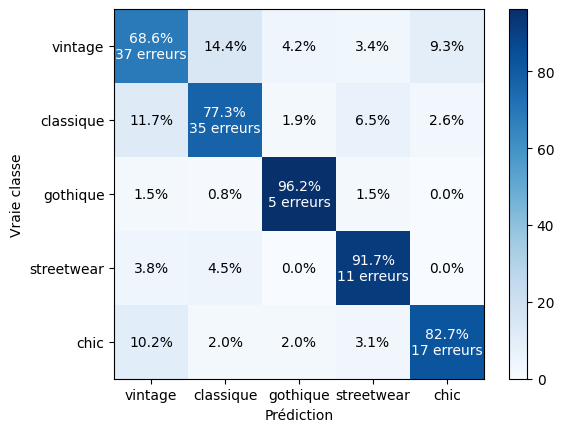

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Prédire les classes sur x_test
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Créer la matrice de confusion
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Calculer les pourcentages
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

# Calculer l'erreur pour chaque classe
classes = ['vintage', 'classique', 'gothique', 'streetwear', 'chic']
errors = []
for i in range(len(classes)):
    errors.append(sum(confusion_mtx[i]) - confusion_mtx[i][i])

# Afficher la matrice de confusion avec les pourcentages et les erreurs
fig, ax = plt.subplots()
im = ax.imshow(confusion_mtx_percent, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel('Prédiction')
ax.set_ylabel('Vraie classe')

# Ajouter les erreurs à la matrice de confusion
for i in range(len(classes)):
    for j in range(len(classes)):
        if i == j:
            ax.text(j, i, '{:.1f}%\n{} erreurs'.format(confusion_mtx_percent[i, j], errors[i]), ha='center', va='center', color='white')
        else:
            ax.text(j, i, '{:.1f}%'.format(confusion_mtx_percent[i, j]), ha='center', va='center', color='black')

plt.show()
